# Game to Movie Video Conversion

## Main Imports

In [116]:
import os

from google.colab import drive
drive.mount('/content/drive')

import cv2
import random
import natsort
import numpy as np
from matplotlib import pyplot as plt

from scipy.linalg import sqrtm
from skimage.transform import resize

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model, Input, load_model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-vn5ciqvp
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-vn5ciqvp
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=b96788c4debccddc10d5c3a971ec62e0c57118ef27b9b8a7e6c31101ff3adaf8
  Stored in directory: /tmp/pip-ephem-wheel-cache-7qy82x53/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


## Preprocess the video data


### Initialise file paths

In [ ]:
main_path = '/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/'
game_load_path = main_path + 'data/game/MafiaVideogame.mp4'
game_frame_save_path = main_path + 'data/game/frames/'
game_problem_frames = [6510, 6698, 11774, 11962, 15158, 20798, 22490, 23054, 29070, 34334, 34522, 41290, 41478, 49562, 49750, 
                       65730, 65918, 66106, 69302, 73438, 73626, 74002, 80018, 80206, 87162, 89230, 92426, 96938, 103518,
                      103706, 103894, 116302, 130590, 130778, 138298, 138486, 142058, 147510, 147698, 154654, 154842, 157662,
                      166686, 166874, 173642, 173830, 180410, 192066, 192254, 196578, 202406, 202594, 207106, 214626, 221582,
                      221770, 228914, 229102]

movies_folder = main_path + 'data/movie/'
movie_frame_save_path = main_path + 'data/movie/frames/'

# data holding start frame, end frame, frame skip
movie_data = {
    "TheGodfather.mp4": (204, 12204, 30, [1074, 1104, 1134, 1164, 1194]),
    "TheIrishman.mp4": (75, 23275, 58, [12603, 12661, 12719]),
    "TheSopranos.mp4": (80, 51280, 128, [9424, 11472, 27984, 28112, 28240, 48848])
}

### Write frames from video files

In [ ]:
def write_frames(video_path, save_path, problem_frames, start_frame, end_frame, frame_skip, counter):
    
    # initialise frame capturing
    vidcap = cv2.VideoCapture(video_path)
    vidcap.set(1, start_frame)
    success, image = vidcap.read()
    frame_number = start_frame
    
    while success and frame_number < end_frame:

        # save frames as images, capturing every frame_skip frames
        cv2.imwrite(save_path + '%d.jpg' % counter, image)
        frame_number += frame_skip
        counter += 1
        
        if frame_number in problem_frames:
            original_frame_number = frame_number
            random_frame = random.randint(start_frame, end_frame)
            vidcap.set(1, random_frame)
            frame_number = original_frame_number
        else:
            vidcap.set(1, frame_number)
        success, image = vidcap.read()

### Read frames from game file

In [ ]:
write_frames(game_load_path, game_frame_save_path, game_problem_frames, 6510, 232110, 188, counter=1)

/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/data/game/MafiaVideogame.mp4


### Read frames from movie files

In [ ]:
counter = 1
for movie_name, frame_data in movie_data.items():
    
    movie_load_path = movies_folder + movie_name
    start_frame, end_frame, frame_skip, movie_problem_frames = frame_data[0], frame_data[1], frame_data[2], frame_data[3]
    write_frames(movie_load_path, movie_save_path, movie_problem_frames, start_frame, end_frame, frame_skip, counter)
    counter += 400

/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/data/movie/TheGodfather.mp4
/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/data/movie/TheIrishman.mp4
/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/data/movie/TheSopranos.mp4


### Set train/test sizes and paths

In [ ]:
game_frame_train_path = main_path + 'data/frame_to_frame/game_train/'
game_frame_test_path = main_path + 'data/frame_to_frame/game_test/'

movie_frame_train_path = main_path + 'data/frame_to_frame/movie_train/'
movie_frame_test_path = main_path + 'data/frame_to_frame/movie_test/'

frame_data_length = len(os.listdir(game_frame_save_path))
frame_train_size = int(0.8 * frame_data_length)
frame_test_size = int(0.2 * frame_data_length)

game_frame_filenames = natsort.natsorted(os.listdir(game_frame_save_path))
movie_frame_filenames = natsort.natsorted(os.listdir(movie_frame_save_path))

print("Frame Training Set Size: ", frame_train_size)
print("Frame Testing Set Size:  ", frame_test_size)

Frame Training Set Size:  960
Frame Testing Set Size:   240


### Function to split the data into folders

In [ ]:
def split_data(size, data, save_path, new_save_path):
    
    for i in range(size[0], size[1]):

        image_name = data[i]
        image_path = save_path + image_name

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        cv2.imwrite(new_save_path + image_name, image)

### Splitting the data

In [ ]:
# split game frame data
split_data((0, frame_train_size), game_frame_filenames, game_frame_save_path, game_frame_train_path)
split_data((frame_train_size, data_length), game_frame_filenames, game_frame_save_path, game_frame_test_path)

# split movie frame data
split_data((0, frame_train_size), movie_data_filenames, movie_save_path, movie_frame_train_path)
split_data((frame_train_size, data_length), movie_data_filenames, movie_save_path, movie_frame_test_path)

### Load the data into an array

In [119]:
def load_images(path, size=(256, 256)):
    
    data_list = list()
    
    for filename in os.listdir(path):
        
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        pixels = img_to_array(pixels)
        data_list.append(pixels)
    
    return np.asarray(data_list)

### Save the data

In [ ]:
game_data = load_images(game_frame_train_path)
movie_data = load_images(movie_frame_train_path)

np.savez_compressed(main_path + 'data/game2movie.npz', game_data, movie_data)
print('Saved dataset')

Saved dataset


## CycleGAN Model

### Discriminator

In [ ]:
def define_discriminator(image_shape):

    # weight initialisation and fetch image input
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    # Convolution-32
    #d = Conv2D(32, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    #d = LeakyReLU(alpha=0.2)(d)

    # Convolution-64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolution-128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolution-256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolution-512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # get patch output and define model
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    model = Model(in_image, patch_out)

    # compile model and return
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

### Resnet Block

In [ ]:
def resnet_block(n_filters, input_layer):

    init = RandomNormal(stddev=0.02)     # weight initialization

    # first convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)

    # concatenate merge channel-wise with input layer and return
    g = Concatenate()([g, input_layer])
    return g

### Generator

In [ ]:
def define_generator(image_shape, n_resnet=9):

    # weight initialization and fetch image input
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    # c7s1-32
    #g = Conv2D(32, (7,7), padding='same', kernel_initializer=init)(in_image)
    #g = InstanceNormalization(axis=-1)(g)
    #g = Activation('relu')(g)

    # d64
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # create resnet blocks
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    
    # u128
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # u32
    #g = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    #g = InstanceNormalization(axis=-1)(g)
    #g = Activation('relu')(g)

    # c7s1-3
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)

    # define model and return
    model = Model(in_image, out_image)
    return model

### Composite Model for Generator Training with Adversarial and Cycle loss

In [ ]:
def define_composite_model(generator_1, discriminator, generator_2, image_shape):
    
    # ensure the model we're updating is trainable
    generator_1.trainable = True

    # mark discriminator and other generator model as not trainable
    discriminator.trainable = False
    generator_2.trainable = False

    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = generator_1(input_gen)
    output_d = discriminator(gen1_out)

    # identity element
    input_id = Input(shape=image_shape)
    output_id = generator_1(input_id)

    # forward cycle
    output_f = generator_2(gen1_out)

    # backward cycle
    gen2_out = generator_2(input_id)
    output_b = generator_1(gen2_out)

    # define model graph and Adam optimiser
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    opt = Adam(lr=0.0002, beta_1=0.5)

    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

### Load and prepare training images

In [ ]:
def load_real_samples(filename):

    # load the dataset and unpack arrays
    data = np.load(filename)
    X1, X2 = data['arr_0'], data['arr_1']

    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    
    return [X1, X2]

### Select batch of random samples and return images and target

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):

    # choose random instances and retrieve selected images
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

### Generate batch of images and return images and targets

In [ ]:
def generate_fake_samples(generator, dataset, patch_shape):

    # generate fake instance and create 'fake' class labels (0)
    X = generator.predict(dataset)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))

    return X, y

### Save the generators

In [ ]:
def save_models(step, generator_game_to_movie, generator_movie_to_game):

    # save the first generator model
    filename1 = 'face_generator_game_to_movie_%03d.h5' % (step+1)
    generator_game_to_movie.save(main_path + '/models/' + filename1)

    # save the second generator model
    filename2 = 'face_generator_movie_to_game_%03d.h5' % (step+1)
    generator_movie_to_game.save(main_path + '/models/' + filename2)

    print('>Saved: %s and %s' % (filename1, filename2))

### Plot a summary of the performance

In [ ]:
def summarize_performance(step, generator, trainX, name, n_samples=5):

    # select a sample of input images and generate translated images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    X_out, _ = generate_fake_samples(generator, X_in, 0)

    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0

    # plot real images
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_in[i])

    # plot translated image
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_out[i])
    
    # save plot to file
    filename1 = main_path + '/results/' + 'face_%s_%03d.png' % (name, (step+1))
    plt.savefig(filename1)

### Update the image pool for fake images

In [ ]:
def update_image_pool(pool, images, max_size=50):

    selected = list()   # initialise selected image list

    for image in images:

        if len(pool) < max_size:

            # stock the pool
            pool.append(image)
            selected.append(image)

        elif random.random() < 0.5:

            # use image, but don't add it to the pool
            selected.append(image)

        else:

            # replace an existing image and use replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image

    # return as array
    return np.asarray(selected)

### Training loop

In [ ]:
def train(discriminator_game, discriminator_movie, generator_game_to_movie, generator_movie_to_game, composite_game_to_movie, composite_movie_to_game, dataset):

    # define properties of the training run and determine the output square shape of the discriminator
    epochs, batch_size, = 50, 4
    patch_size = discriminator_game.output_shape[1]

    # unpack dataset and prepare image pool for fakes
    game_train, movie_train = dataset
    poolA, poolB = list(), list()

    # calculate the number of batches per training epoch
    batches_per_epoch = int(len(game_train) / batch_size)
    print("Training for", epochs, "epochs on a batch size of", batch_size, "with", batches_per_epoch, "batches per epoch")

    for epoch in range(1, epochs + 1):
        for batch in range(batches_per_epoch):

            # select a batch of real samples
            X_realA, y_realA = generate_real_samples(game_train, batch_size, patch_size)
            X_realB, y_realB = generate_real_samples(movie_train, batch_size, patch_size)

            # generate a batch of fake samples
            X_fakeA, y_fakeA = generate_fake_samples(generator_movie_to_game, X_realB, patch_size)
            X_fakeB, y_fakeB = generate_fake_samples(generator_game_to_movie, X_realA, patch_size)

            # update fakes from pool
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)

            # update generator B->A via adversarial and cycle loss
            g_loss2, _, _, _, _  = composite_movie_to_game.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])

            # update discriminator for A -> [real/fake]
            discriminator_game_real_loss = discriminator_game.train_on_batch(X_realA, y_realA)
            discriminator_game_fake_loss = discriminator_game.train_on_batch(X_fakeA, y_fakeA)

            # update generator A->B via adversarial and cycle loss
            g_loss1, _, _, _, _ = composite_game_to_movie.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

            # update discriminator for B -> [real/fake]
            discriminator_movie_real_loss = discriminator_game.train_on_batch(X_realB, y_realB)
            discriminator_movie_fake_loss = discriminator_game.train_on_batch(X_fakeB, y_fakeB)
        
        # output losses after every epoch
        print('> Epoch %d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' %\
              (epoch, discriminator_game_real_loss, discriminator_game_fake_loss, discriminator_game_real_loss, discriminator_movie_fake_loss, g_loss1, g_loss2))

        # evaluate and save the model intermittently
        if epoch % 5 == 0:
            summarize_performance(epoch, generator_game_to_movie, game_train, 'gametomovie')  # plot game -> movie translation
            summarize_performance(epoch, generator_movie_to_game, movie_train, 'movietogame')  # plot movie -> game translation
            save_models(epoch, generator_game_to_movie, generator_movie_to_game)

### Train on the frame dataset

In [ ]:
# load image data and define input shape based on the loaded dataset
dataset = load_real_samples(main_path + 'data/game2movie.npz')
image_shape = dataset[0].shape[1:]
print('Loaded dataset with shape:', dataset[0].shape, dataset[1].shape)

# define generators
generator_game_to_movie = define_generator(image_shape)
generator_movie_to_game = define_generator(image_shape)

# define discriminators
discriminator_game = define_discriminator(image_shape)
discriminator_movie = define_discriminator(image_shape)

# define composite models 
composite_game_to_movie = define_composite_model(generator_game_to_movie, discriminator_movie, generator_movie_to_game, image_shape)   # game -> movie -> [real/fake, game]
composite_movie_to_game = define_composite_model(generator_movie_to_game, discriminator_game, generator_game_to_movie, image_shape)   # movie -> game -> [real/fake, movie]

# train models
train(discriminator_game, discriminator_movie, generator_game_to_movie, generator_movie_to_game, composite_game_to_movie, composite_movie_to_game, dataset)

## Frame-to-Frame Results

### Single image load function

In [ ]:
def load_image(filename, size=(256, 256)):

    # load and resize the image and convert to numpy array
    pixels = load_img(filename, target_size=size)
    pixels = img_to_array(pixels)

    # transform in a sample and scale from [0,255] to [-1,1]
    pixels = np.expand_dims(pixels, 0)
    pixels = (pixels - 127.5) / 127.5

    return pixels

cust = {'InstanceNormalization': InstanceNormalization}

### Translate a sample of images to the opposite domain and display them

In [ ]:
def display_results(generator, test_path, name, sample_size):

    test_sample = random.sample([i for i in range(961, 1200)], sample_size)
    fake_frame_list = []

    for filename in test_sample:
        test_frame = load_image(test_path + str(filename) + '.jpg')
        fake_frame = generator.predict(test_frame)
        fake_frame_list.append(fake_frame)

    fig = plt.figure(figsize=(24, 12))
    columns = sample_size
    rows = 2

    for i in range(1, columns*rows + 1):

        ax = fig.add_subplot(rows, columns, i)

        if i < 6:
            filename = str(test_sample[i - 1])
            frame = load_image(test_path + filename + '.jpg')
            ax.title.set_text(name + filename)
        else:
            frame = fake_frame_list[i - 6]
            ax.title.set_text('Fake' + name + str(test_sample[i - 6]))

        frame = (frame + 1) / 2.0
        plt.imshow(frame[0])

    plt.show()

### Load game-to-movie frame model and display its results

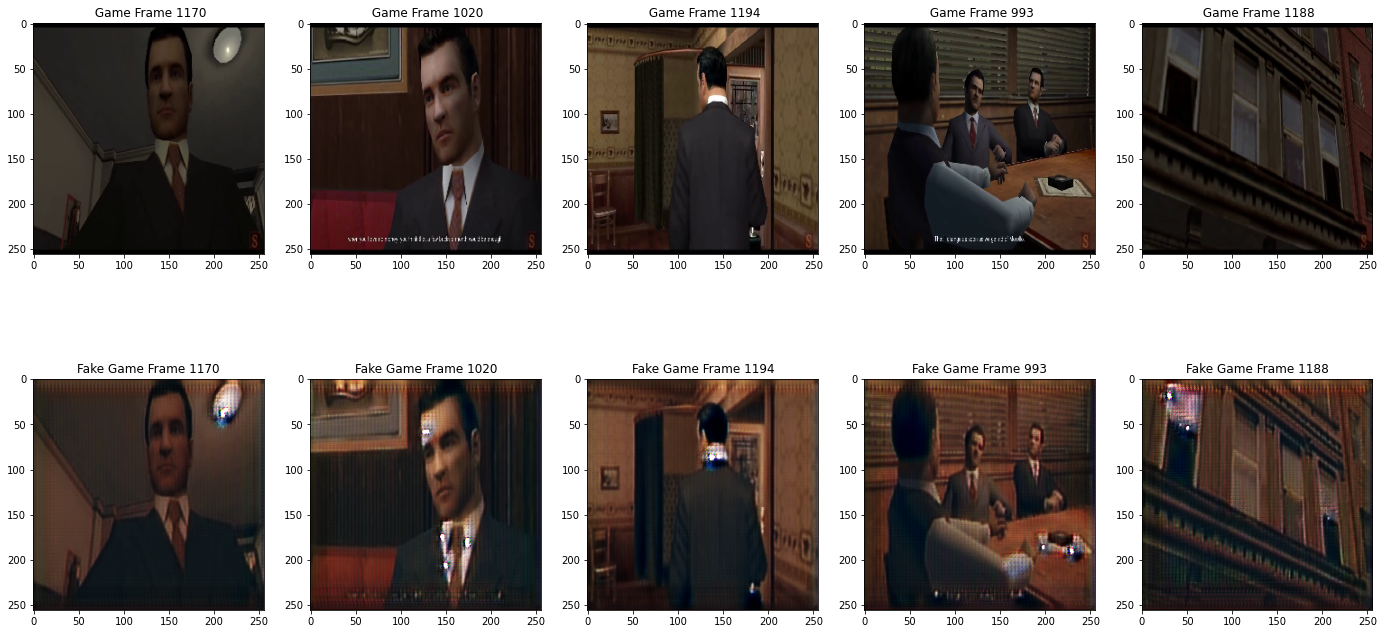

In [150]:
game_to_movie_frame_model_path = main_path + 'models/g_model_AtoB_000026.h5'
game_to_movie_frame_model = load_model(game_to_movie_frame_model_path, cust)

game_test_name = ' Game Frame '
display_results(game_to_movie_frame_model, game_frame_test_path, game_test_name, 5)

### Load movie-to-game frame model and display its results

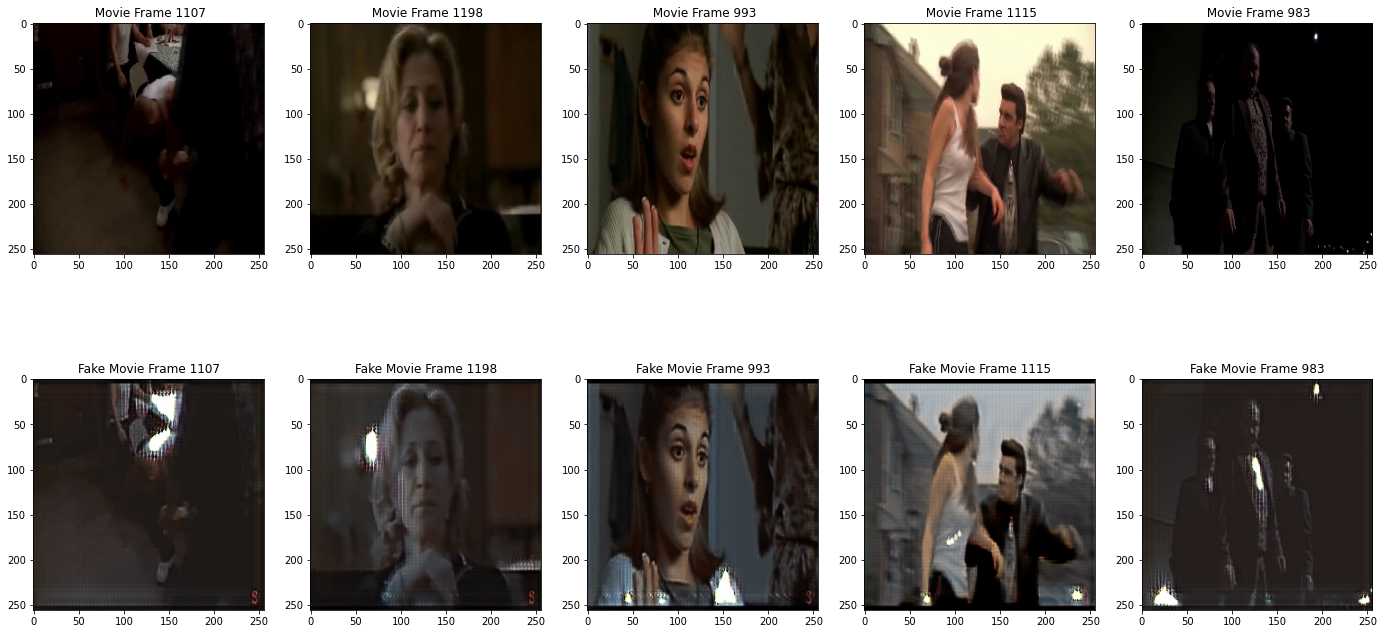

In [ ]:
movie_to_game_frame_model_path = main_path + 'models/g_model_BtoA_000026.h5'
movie_to_game_frame_model = load_model(movie_to_game_frame_model_path, cust)

movie_test_name = ' Movie Frame '
display_results(movie_to_game_frame_model, movie_frame_test_path, movie_test_name, 5)

## Face Detection, Extraction, and Data Setup

### Detect faces in an image

In [117]:
face_detector = cv2.CascadeClassifier(main_path + 'data/haarcascade_frontalface_default.xml')

def detect_faces(image):

    face_list = face_detector.detectMultiScale(image, 1.1, 20)
    return list(face_list)

### Pass frames to face detector and save face outputs

In [ ]:
def extract_faces(domain_name, filenames, frame_load_path, face_save_path, problem_faces):

    num_faces = 0

    for i in range(1, len(filenames) + 1):


        frame_file_path = frame_load_path + str(i) + '.jpg'
        frame = cv2.imread(frame_file_path, cv2.IMREAD_COLOR)
        face_list = detect_faces(frame)

        if face_list:

            for j in range(0, len(face_list)):

                if (i, j) not in problem_faces:

                    (x, y, w, h) = face_list[j]
                    face = frame[y:y+h, x:x+w]
                    cv2.imwrite(face_save_path + str(i) + '_' + str(j) + '.jpg', face)

            num_faces += len(face_list)

    print("Total " + domain_name + " faces:", num_faces)

### Set face write paths

In [ ]:
game_frame_load_path = main_path + 'data/game/frames/'
game_face_save_path = main_path + 'data/game/faces/'
game_problem_faces = [(26, 1), (64, 0), (98, 0), (194, 1), (247, 1), (251, 0), (317, 0), (320, 0), (320, 1), (320, 2), (324, 0), (324, 2),
                      (370, 1), (375, 1), (378, 1), (449, 0), (507, 0), (507, 2), (636, 1), (637, 1), (645, 1), (647, 0), (647, 1), (647, 2),
                      (702, 0), (721, 0), (769, 0), (774, 0), (823, 0), (979, 0), (1098, 1), (1102, 0), (1187, 0)]
game_domain_name = 'game'

movie_frame_load_path = main_path + 'data/movie/frames/'
movie_face_save_path = main_path + 'data/movie/faces/'
movie_problem_faces = [(178, 0), (300, 0), (300, 1), (300, 2), (300, 3), (300, 4), (300, 5), (300, 6), (300, 7), (604, 2), (607, 0),
                       (726, 0), (756, 0), (781, 0), (853, 2), (906, 1), (909, 0), (937, 0), (941, 0)]
movie_domain_name = 'movie'

### Compute faces for game frames and movie frames

In [ ]:
extract_faces(game_domain_name, game_frame_filenames, game_frame_load_path, game_face_save_path, game_problem_faces)
extract_faces(movie_domain_name, movie_frame_filenames, movie_frame_load_path, movie_face_save_path, movie_problem_faces)

### Set face training and testing paths

In [ ]:
game_face_train_path = main_path + 'data/face_to_face/game_train/'
game_face_test_path = main_path + 'data/face_to_face/game_test/'

movie_face_train_path = main_path + 'data/face_to_face/movie_train/'
movie_face_test_path = main_path + 'data/face_to_face/movie_test/'

game_face_data_length = len(os.listdir(game_face_save_path))
game_face_train_size = int(0.8 * game_face_data_length)
game_face_test_size = int(0.2 * game_face_data_length)

movie_face_data_length = len(os.listdir(movie_face_save_path))
movie_face_train_size = int(0.8 * movie_face_data_length)
movie_face_test_size = int(0.2 * movie_face_data_length)

game_face_filenames = natsort.natsorted(os.listdir(game_face_save_path))
movie_face_filenames = natsort.natsorted(os.listdir(movie_face_save_path))

print("Game Face Training Set Size: ", game_face_train_size)
print("Game Face Testing Set Size:  ", game_face_test_size)
print("Movie Face Training Set Size:", movie_face_train_size)
print("Movie Face Testing Set Size: ", movie_face_test_size)

Game Face Training Set Size:  461
Game Face Testing Set Size:   115
Movie Face Training Set Size: 342
Movie Face Testing Set Size:  85


In [ ]:
def split_face_data(midpoint, save_path, train_save_path, test_save_path):

    import os
    directory = os.fsencode(save_path)
    counter = 0

    for file in os.listdir(directory):
    
        filename = os.fsdecode(file)
        image_path = save_path + filename
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        if counter < midpoint:

            cv2.imwrite(train_save_path + filename, image)
        
        else:

            cv2.imwrite(test_save_path + filename, image)

        counter += 1

### Split faces into training and testing sets

In [ ]:
# split game face data
split_face_data(game_face_train_size, game_face_save_path, game_face_train_path, game_face_test_path)

# split movie face data
split_face_data(movie_face_train_size, movie_face_save_path, movie_face_train_path, movie_face_test_path)

### Save the face dataset

In [ ]:
game_face_data = load_images(game_face_train_path)
movie_face_data = load_images(movie_face_train_path)

np.savez_compressed(main_path + 'game2movieface.npz', game_face_data, movie_face_data)
print('Saved face dataset')

Saved face dataset


### Train on the face dataset

Loaded dataset with shape: (461, 256, 256, 3) (342, 256, 256, 3)
Training for 50 epochs on a batch size of 4 with 115 batches per epoch
> Epoch 1, dA[0.044,0.062] dB[0.044,0.022] g[9.586,9.377]
> Epoch 2, dA[0.026,0.056] dB[0.026,0.017] g[8.426,8.563]
> Epoch 3, dA[0.022,0.019] dB[0.022,0.013] g[9.963,10.219]
> Epoch 4, dA[0.022,0.046] dB[0.022,0.019] g[7.767,7.981]
> Epoch 5, dA[0.066,0.035] dB[0.066,0.008] g[8.275,9.047]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


>Saved: face_generator_game_to_movie_006.h5 and face_generator_movie_to_game_006.h5
> Epoch 6, dA[0.072,0.034] dB[0.072,0.008] g[7.810,8.020]
> Epoch 7, dA[0.005,0.020] dB[0.005,0.003] g[7.323,7.778]
> Epoch 8, dA[0.040,0.023] dB[0.040,0.005] g[7.198,8.469]
> Epoch 9, dA[0.011,0.003] dB[0.011,0.002] g[7.006,7.756]
> Epoch 10, dA[0.010,0.017] dB[0.010,0.004] g[8.146,8.516]
>Saved: face_generator_game_to_movie_011.h5 and face_generator_movie_to_game_011.h5
> Epoch 11, dA[0.074,0.125] dB[0.074,0.015] g[5.939,5.852]
> Epoch 12, dA[0.033,0.045] dB[0.033,0.006] g[5.394,5.890]
> Epoch 13, dA[0.059,0.064] dB[0.059,0.008] g[5.805,6.415]
> Epoch 14, dA[0.012,0.025] dB[0.012,0.009] g[6.130,7.126]
> Epoch 15, dA[0.013,0.020] dB[0.013,0.002] g[5.127,5.641]
>Saved: face_generator_game_to_movie_016.h5 and face_generator_movie_to_game_016.h5
> Epoch 16, dA[0.105,0.032] dB[0.105,0.025] g[4.119,4.754]
> Epoch 17, dA[0.009,0.047] dB[0.009,0.006] g[5.026,6.095]
> Epoch 18, dA[0.050,0.045] dB[0.050,0.005] 

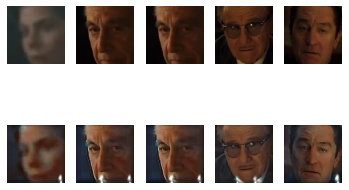

In [ ]:
# load image data and define input shape based on the loaded dataset
dataset = load_real_samples(main_path + 'data/game2movieface.npz')
image_shape = dataset[0].shape[1:]
print('Loaded dataset with shape:', dataset[0].shape, dataset[1].shape)

# define generators
generator_game_to_movie = define_generator(image_shape)
generator_movie_to_game = define_generator(image_shape)

# define discriminators
discriminator_game = define_discriminator(image_shape)
discriminator_movie = define_discriminator(image_shape)

# define composite models 
composite_game_to_movie = define_composite_model(generator_game_to_movie, discriminator_movie, generator_movie_to_game, image_shape)   # game -> movie -> [real/fake, game]
composite_movie_to_game = define_composite_model(generator_movie_to_game, discriminator_game, generator_game_to_movie, image_shape)   # movie -> game -> [real/fake, movie]

# train models
train(discriminator_game, discriminator_movie, generator_game_to_movie, generator_movie_to_game, composite_game_to_movie, composite_movie_to_game, dataset)

## Evaluation

### Load frame testing data

In [133]:
game_frame_test_data = load_images(game_frame_test_path)
movie_frame_test_data = load_images(movie_frame_test_path)
print(game_frame_test_data.shape, movie_frame_test_data.shape)

(240, 256, 256, 3) (240, 256, 256, 3)


### Predict frames for dataset

In [143]:
def get_predicted_dataset(test_path, model):

    predicted_frames_list = []

    for filename in os.listdir(test_path):
        
        # load, resize, and predict
        frame = load_image(test_path + filename)
        fake_frame = model.predict(frame)

        # save to array
        fake_frame_array = img_to_array(fake_frame[0])
        predicted_frames_list.append(fake_frame_array)
        
    return np.asarray(predicted_frames_list)

### Scale an array of images to a new size

In [ ]:
def scale_images(images, new_shape):

    images_list = list()

    for image in images:

        # resize with nearest neighbor interpolation and store
        new_image = resize(image, new_shape, 0)
        images_list.append(new_image)

    return np.asarray(images_list)

### Frechet Inception Distance (FID) Calculator

In [ ]:
def calculate_fid(model, images1, images2):
    
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # calculate sum squared difference between means and sqrt of product between cov
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

### Compute FID score for dataset

In [146]:
def get_FID_score(dataset1, dataset2):

    # prepare the inception v3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    print('Loaded', dataset1.shape, dataset2.shape)

    # convert integer to floating point values
    dataset1_float = dataset1.astype('float32')
    dataset2_float = dataset2.astype('float32')

    # resize images
    dataset1_scaled = scale_images(dataset1_float, (299, 299, 3))
    dataset2_scaled = scale_images(dataset2_float, (299, 299, 3))
    print('Scaled', dataset1_scaled.shape, dataset2_scaled.shape)

    # pre-process images
    dataset1_preprocessed = preprocess_input(dataset1_scaled)
    dataset2_preprocessed = preprocess_input(dataset2_scaled)

    # calculate fid
    fid = calculate_fid(model, dataset1_preprocessed, dataset2_preprocessed)
    print('FID: %.3f' % fid)
    return fid

### Compute FID score for real movies to generated movies

In [ ]:
generated_movie_dataset = get_predicted_dataset(game_frame_test_path, game_to_movie_frame_model).astype('float32')
get_FID_score(movie_frame_test_data, generated_movie_dataset)